In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import combinations
from tqdm import tqdm
import pycountry
from countryinfo import CountryInfo
import pycountry
from countryinfo import CountryInfo
from tqdm import tqdm
from Countrydetails import country


In [7]:
path = '/Users/g_private/Library/CloudStorage/OneDrive-Personal/Universität Zürich/FS25/Complex Newtworks Yas/data/co-attention.csv'
df=pd.read_csv(path)
df=df.dropna()
df['countries_mentioned_list']=df['countries_mentioned'].apply(lambda x: x.split(','))
df['affiliations_list']=df['affiliations'].apply(lambda x: x.split(','))
df['Mention_number']=df['countries_mentioned_list'].apply(lambda x: len(x))
df['countries_mentioned_list'] = df['countries_mentioned_list'].apply(
    lambda lst: [c.strip().title()           # remove spaces, standard capitalisation
                 .replace('P.R. China', 'China')
                 .replace('Pr China', 'China')
                 .replace('People’s Republic Of China', 'China')
                 .replace('Cn', 'China')
                 for c in lst]
)
df['affiliations_list'] = df['affiliations_list'].apply(
    lambda lst: [c.strip().title()           # remove spaces, standard capitalisation
                 .replace('P.R. China', 'China')
                 .replace('Pr China', 'China')
                 .replace('People’s Republic Of China', 'China')
                 .replace('Cn', 'China')
                 for c in lst])
# flatten with respect to to the aggregated_value column
df = df.loc[df.index.repeat(df['aggregated_value'])].reset_index(drop= True)

df['affiliations_list'] = df['affiliations_list'] \
    .apply(lambda codes: [c.upper() for c in codes])


# List of columns to remove
cols_to_drop = [
    'countries_mentioned',
    'affiliations',
    'aggregated_value',
    #'affiliations_list',
    'Mention_number'
]

# Option 1: create a new DataFrame without those columns
df= df.drop(columns=cols_to_drop)

df['countries_mentioned_list'] = df['countries_mentioned_list'] \
    .apply(lambda codes: [c.upper() for c in codes])
# remove entries with only 1 country mentioned
df = df[df['countries_mentioned_list'].apply(len) > 1]

df['countries_mentioned_list'] = df['countries_mentioned_list'].apply(lambda lst:[c for c in lst if len(c) < 4]) 

df = df[df['countries_mentioned_list'].apply(len) > 1]


# Heatmaps for all countries

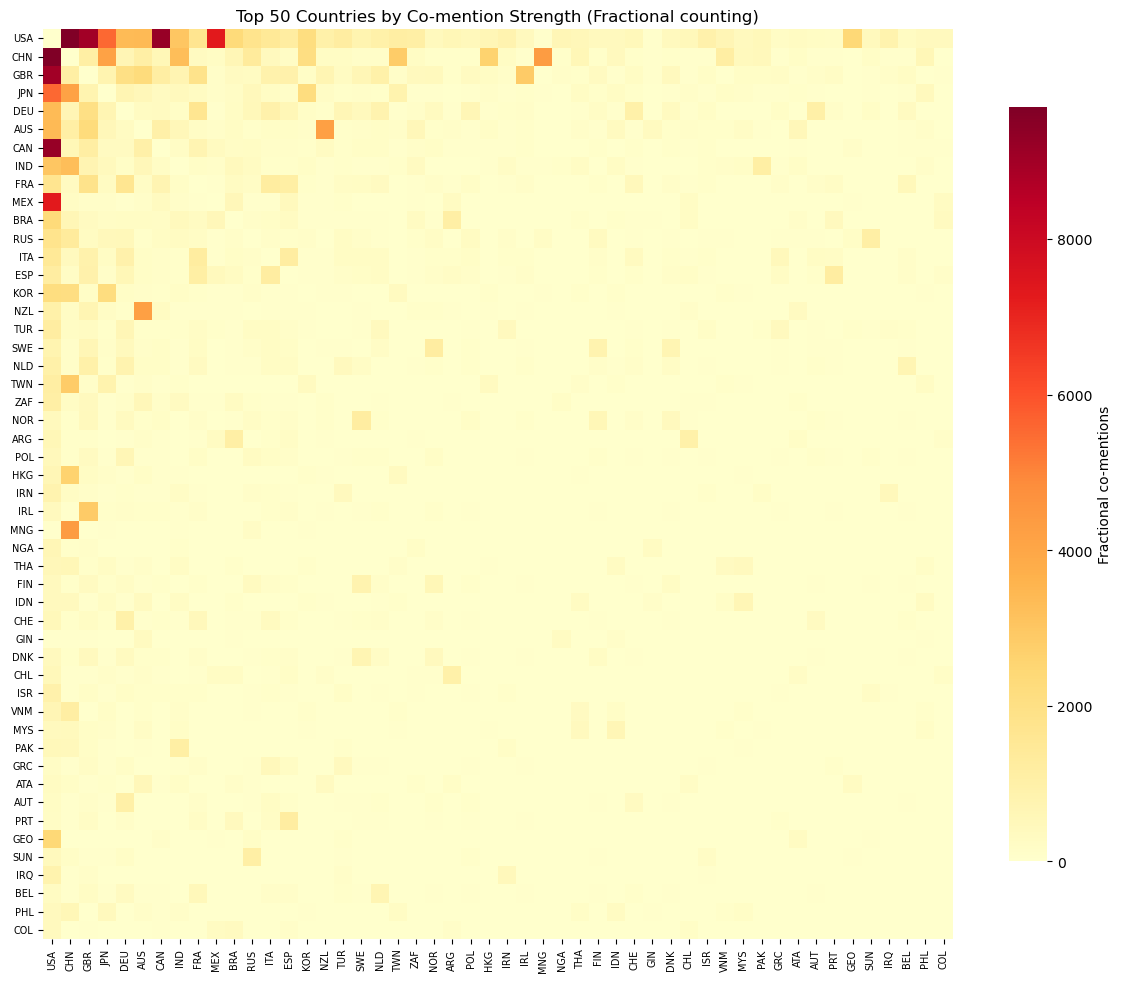

In [4]:
import pandas as pd
import numpy as np
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# --- 0) Assumes df['countries_mentioned_list'] exists and holds lists of ISO-3 codes ---

# --- 1) Build fractional co-mention weights ---
pair_weights = defaultdict(float)

for countries in df["countries_mentioned_list"]:
    # unique countries per paper
    uniq = sorted(set(countries))
    n = len(uniq)
    if n < 2:
        continue  # avoid division by zero; no pairs to count
    weight_per_pair = 1.0 / (n * (n - 1) / 2.0)  # 1 / C(n,2)
    for c1, c2 in itertools.combinations(uniq, 2):
        pair_weights[(c1, c2)] += weight_per_pair
        pair_weights[(c2, c1)] += weight_per_pair  # keep matrix symmetric

# --- 2) Create full country list from the DF (so singletons still appear if needed) ---
all_countries = sorted({c for lst in df["countries_mentioned_list"] for c in lst})

# Initialize the full matrix (symmetric, zeros on diagonal)
matrix = pd.DataFrame(0.0, index=all_countries, columns=all_countries)

# Fill from weights
for (c1, c2), w in pair_weights.items():
    matrix.loc[c1, c2] = w

# Ensure symmetry and zero diagonal (safety)
matrix = (matrix + matrix.T) / 2.0
np.fill_diagonal(matrix.values, 0.0)

# --- 3) Pick the top 50 strongest countries ---
# Since the matrix is symmetric, row sum == col sum. Using row sums is enough.
strength = matrix.sum(axis=1)
topN = 50
top_countries = strength.sort_values(ascending=False).head(topN).index

# Slice and order rows/cols by strength
sub = matrix.loc[top_countries, top_countries]
sub = sub.loc[strength.loc[top_countries].sort_values(ascending=False).index,
              strength.loc[top_countries].sort_values(ascending=False).index]

# --- 4) Plot heatmap ---
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    sub,
    cmap="YlOrRd",
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Fractional co-mentions"},
)

ax.set_title("Top 50 Countries by Co-mention Strength (Fractional counting)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=7)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=7)
plt.tight_layout()
plt.show()


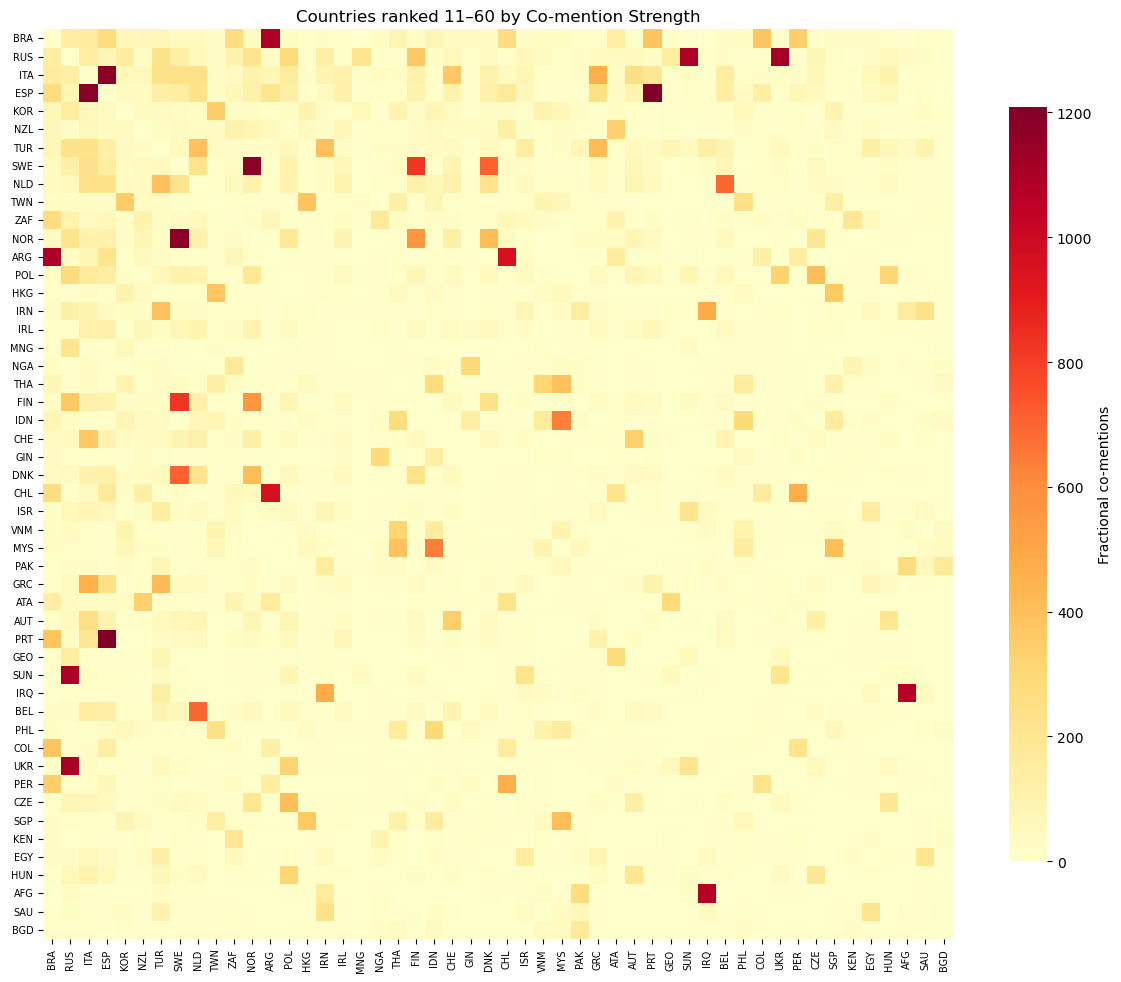

In [5]:
import pandas as pd
import numpy as np
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1) Build fractional co-mention weights ---
pair_weights = defaultdict(float)

for countries in df["countries_mentioned_list"]:
    uniq = sorted(set(countries))
    n = len(uniq)
    if n < 2:
        continue
    weight_per_pair = 1.0 / (n * (n - 1) / 2.0)
    for c1, c2 in itertools.combinations(uniq, 2):
        pair_weights[(c1, c2)] += weight_per_pair
        pair_weights[(c2, c1)] += weight_per_pair

# --- 2) Build matrix from all countries ---
all_countries = sorted({c for lst in df["countries_mentioned_list"] for c in lst})
matrix = pd.DataFrame(0.0, index=all_countries, columns=all_countries)

for (c1, c2), w in pair_weights.items():
    matrix.loc[c1, c2] = w

matrix = (matrix + matrix.T) / 2.0
np.fill_diagonal(matrix.values, 0.0)

# --- 3) Rank countries by total strength ---
strength = matrix.sum(axis=1).sort_values(ascending=False)

# Parameters
k = 10   # exclude this many strongest
n = 50   # take this many after exclusion

# Slice the list: skip top k, take next n
selected_countries = strength.iloc[k:k+n].index

# Submatrix for selected countries
sub = matrix.loc[selected_countries, selected_countries]

# --- 4) Plot heatmap ---
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    sub,
    cmap="YlOrRd",
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Fractional co-mentions"},
)
ax.set_title(f"Countries ranked {k+1}–{k+n} by Co-mention Strength")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=7)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=7)
plt.tight_layout()
plt.show()


# Heatmaps for Subregions

In [8]:
# take all years together
df= df.drop(columns=['Year'])

# 1) build a set of all ISO-3 codes
iso3_set = {c.alpha_3 for c in pycountry.countries}

# 2) define a helper that checks if all entries in a list are in that set
def is_all_iso3(code_list):
    return set(code_list).issubset(iso3_set)

# 3) apply it as a boolean mask
mask = df['countries_mentioned_list'].apply(is_all_iso3)

# 4) select only those rows
df = df[mask]



# 1) Build the mapping dict once
iso3_to_sub = {}
for country in pycountry.countries:
    try:
        sub = CountryInfo(country.name).subregion()
    except KeyError:
        sub = None
    iso3_to_sub[country.alpha_3] = sub

# 2b) Or, if you’d like to see a progress bar:
tqdm.pandas(desc="Mapping subregions")
df['subregions'] = df['countries_mentioned_list'] \
    .progress_map(lambda codes: [iso3_to_sub.get(c.upper()) for c in codes])

# 1) remove rows where '' appears in the country list
mask_no_empty = df['subregions'].apply(lambda codes: '' not in codes)
df = df[mask_no_empty]

Mapping subregions: 100%|██████████| 344547/344547 [00:00<00:00, 524585.28it/s] 


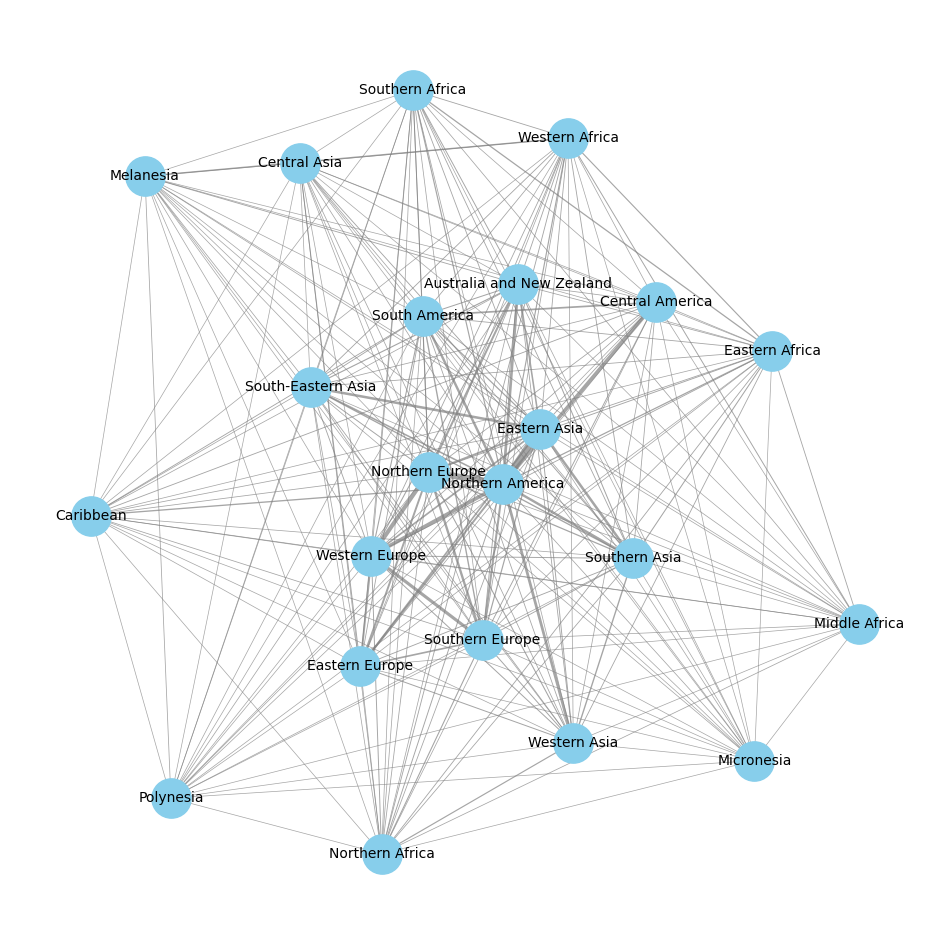

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
import itertools
from collections import Counter
from math import comb

def build_fractional_comention_network(df, list_col='subregions', min_weight=0.005):
    """
    Pair-normalized fractional co-mention network:
      - Each paper with k subregions contributes 1 / comb(k,2) to each pair.
      - Edges with total weight ≥ min_weight appear in the graph.
      - Self‐loops are explicitly removed.
    """
    pair_weights = Counter()

    # 1) accumulate fractional weights per paper
    for regs in df[list_col]:
        uniq = [r for r in regs if r is not None]
        k = len(uniq)
        if k < 2:
            continue
        frac = 1.0 / comb(k, 2)
        for u, v in itertools.combinations(sorted(uniq), 2):
            pair_weights[(u, v)] += frac

    # 2) build graph
    G = nx.Graph()
    all_regs = {r for regs in df[list_col] for r in regs if r is not None}
    G.add_nodes_from(all_regs)

    for (u, v), w in pair_weights.items():
        if w >= min_weight:
            G.add_edge(u, v, weight=w)

    # 3) remove any accidental self loops
    G.remove_edges_from(nx.selfloop_edges(G))

    return G

# --- parameters you can tweak ---
MIN_WEIGHT = 0.01   # drop edges whose total fractional weight < 1% of a paper
SPRING_K   = 20    # repulsion parameter for layout
FIGSIZE    = (12, 12)

# build & draw
G_frac = build_fractional_comention_network(df, list_col='subregions', min_weight=MIN_WEIGHT)

# extract and normalize edge‐widths
weights = [G_frac[u][v]['weight'] for u, v in G_frac.edges()]
mn, mx = min(weights), max(weights)
widths = [0.5 + 4.5 * ((w - mn) / (mx - mn)) for w in weights]

plt.figure(figsize=FIGSIZE)
pos = nx.spring_layout(G_frac, k=SPRING_K, seed=42)

nx.draw_networkx_nodes(G_frac, pos,
                       node_size=800,
                       node_color='skyblue')
nx.draw_networkx_edges(G_frac, pos,
                       width=widths,
                       edge_color='gray',
                       alpha=0.7)
nx.draw_networkx_labels(G_frac, pos, font_size=10)

#plt.title(f"Fractional Subregion Co‐mention (min_weight={MIN_WEIGHT})")
plt.axis('off')
plt.show()


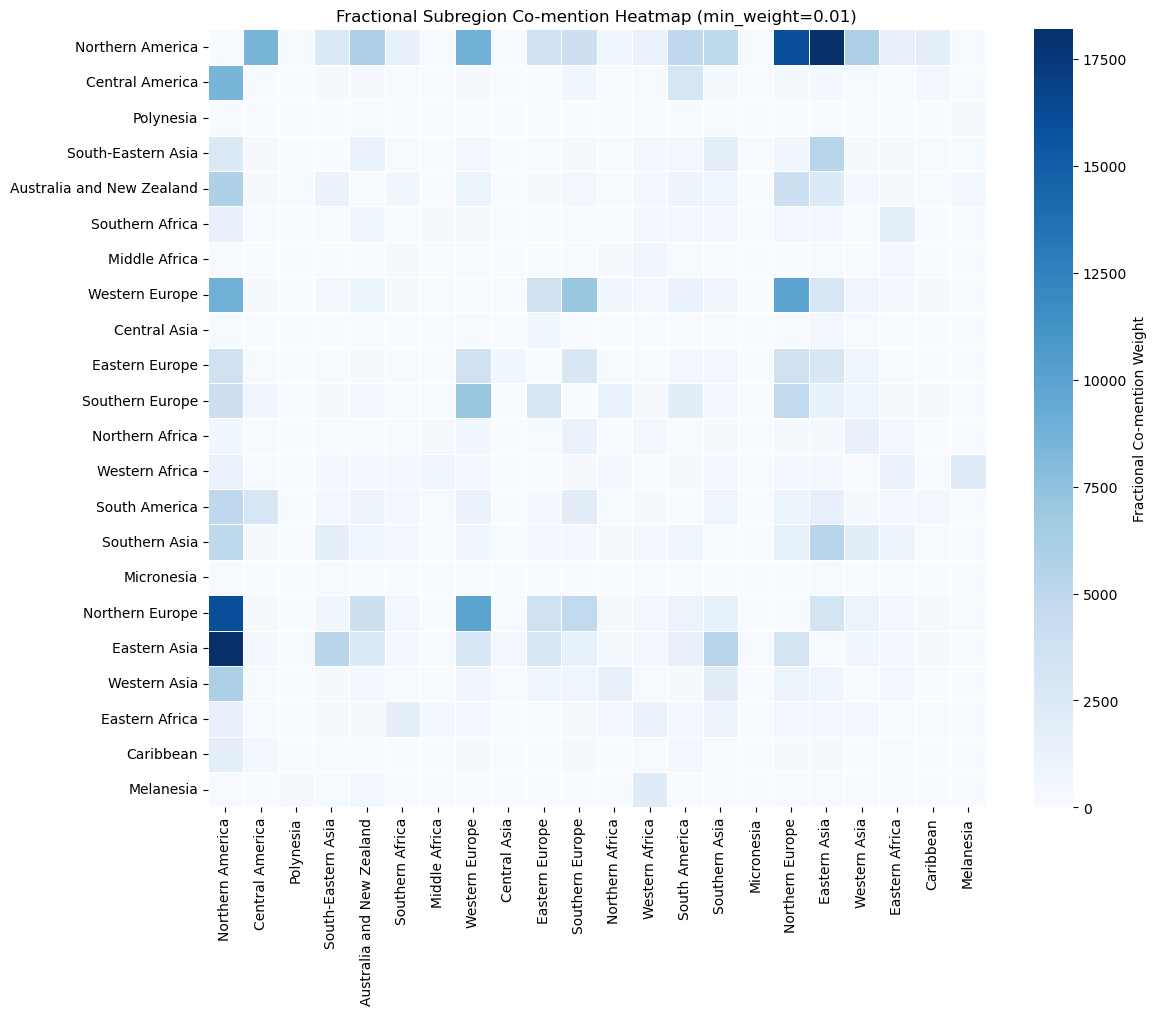

In [10]:
import pandas as pd
import seaborn as sns

# 1) Convert graph edges to a weighted adjacency matrix
adj = nx.to_pandas_adjacency(G_frac, weight="weight")

# 2) Plot as heatmap
plt.figure(figsize=(12,10))
sns.heatmap(adj,
            cmap="Blues", 
            linewidths=0.5, 
            square=True,
            cbar_kws={"label": "Fractional Co-mention Weight"})

plt.title(f"Fractional Subregion Co-mention Heatmap (min_weight={MIN_WEIGHT})")
plt.tight_layout()
plt.show()
